In [ ]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import missingno as msno
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib_scalebar.scalebar import ScaleBar
from splot import esda as esdaplot

# Geospatial analysis
import geopandas as gpd
from pysal.model import spreg
from pysal.viz import splot
from splot.esda import plot_moran
from pysal.lib import weights
from pysal.explore import esda
from numpy.random import seed

# MGWR
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap

# Math and Statistical functions
import math
from scipy import stats

# CBS Open Data
import cbsodata

# Libpysal
import libpysal as ps

# Warnings
import warnings

# Extract & Load files

This section of the notebook focuses on extracting relevant data from various sources using Python packages. The extracted data includes:
- **CBS '21 Socio-economic Data:** We extract socio-economic data from the CBS (Central Bureau of Statistics) package for the year '21. This data provides valuable insights into various socio-economic indicators.
- **CBS '20 Socio-economic Data:** We also extract the same dataset for the year '20, because the dataset contains some data that is missing in the '21 dataset. In this way, we are able to perform data imputation, where appropriate. 


Apart from the CBS data, our analysis and modeling also incorporate other datasets that have been precomputed or obtained through other sources. These datasets include:
- **Buurts Polygon Geometries**: polygon geometries representing neighborhoods (buurts) identified by their unique IDs. These geometries help us visualize and analyze the spatial distributions at the neighborhood level.
- **Wijks Polygon Geometries**: polygon geometries representing districts (wijks) identified by their unique IDs. These geometries provide a higher-level view  of spatial distributions at the district level.- **Precomputed VGVI**: Viewshed Greenness Visibility Index (VGVI) is a precomputed dataset that provides information about tree visibility at 50m intervals of every Dutch street.

In [2]:
se_data_21 = pd.DataFrame(cbsodata.get_data('85039NED')) # Extract socio-economic indicators data from CBS for 2021
se_data_20 = pd.DataFrame(cbsodata.get_data('84799NED')) # Extract socio-economic indicators data from CBS for 2021

# Save the data locally
se_data_21.to_csv('data_collection/cbs_data/se_data_21.csv', index=False) # save the data locally
se_data_20.to_csv('data_collection/cbs_data/se_data_20.csv', index=False) # save the data locally

In [4]:
# load calculated vgvi for the entire NED
vgvi_data = gpd.read_file('vgvi/ned_vgvi_indexed_V2.gpkg')

In [5]:
# load the extracted cbs data 
se_data_21 = pd.read_csv('data_collection/cbs_data/se_data_21.csv')
se_data_20 = pd.read_csv('data_collection/cbs_data/se_data_20.csv')

In [6]:
# load burt and wijk data with polygons for aggregation purposes
neighborhood_gdf = gpd.read_file("data_collection/cbs_data/WijkBuurtkaart_2022_v1/buurt_2022_v1.shp")
district_gdf = gpd.read_file("data_collection/cbs_data/WijkBuurtkaart_2022_v1/wijk_2022_v1.shp")

# Data preprocessing

Data preprocessing step involves the following steps: 
- **Cleaning the cbs dataset**
- **Feature engineering**
- **Exploratory data analysis**
- **Aggregating the data**

## Data cleaning & feature engineering

In [7]:
# rename columns 
rename_dict = {'SoortRegio_2': 'type',
               'k_0Tot15Jaar_8': 'age_0_15',
                'k_15Tot25Jaar_9': 'age_15_25',
                'k_25Tot45Jaar_10': 'age_25_45',
                'k_45Tot65Jaar_11': 'age_45_65',
                'k_65JaarOfOuder_12': 'age_65_older',
               'Gemeentenaam_1': 'Gemeentenaam',
               'Codering_3': 'code',
                'Mannen_6': 'population',
               'WestersTotaal_17': 'western_background',
               'NietWestersTotaal_18': 'non_western_background',
               'GeboorteRelatief_25': 'birth_rate_1000',
               'SterfteRelatief_27': 'mortality_1000',
               'GemiddeldeHuishoudensgrootte_32': 'avg_household_size',
               'Bevolkingsdichtheid_33': 'population_density',
               'GemiddeldeWOZWaardeVanWoningen_35': 'avg_values_home',
               'GemiddeldElektriciteitsverbruikTotaal_47': 'avg_eletricity_cons',
               'GemiddeldAardgasverbruikTotaal_55': 'avg_nat_gas_cons',
               'Huurwoning_61': 'rental_home',
               'EigenWoning_62': 'non_rental_home',
               'OpleidingsniveauLaag_64': 'educ_low',
               'OpleidingsniveauMiddelbaar_65': 'educ_secondary',
               'OpleidingsniveauHoog_66': 'educ_high',
               'BedrijfsvestigingenTotaal_91': 'companies_total',
               'PersonenautoSPerHuishouden_103': 'cars_per_household',
               'MateVanStedelijkheid_116': 'degree_urbanity',
               'AantalInkomensontvangers_70': 'income_recipients_total',
               'GemiddeldInkomenPerInwoner_72': 'avg_income_inhabitant',
               'GemiddeldInkomenPerInkomensontvanger_71': 'avg_income_recipient',  
               'GemGestandaardiseerdInkomenVanHuish_75': 'avg_income_stand_household_1000'
}

columns_to_keep = ['WijkenEnBuurten']  # columns not to be changed but included

# Rename and filter columns in the CBS socioeconomic data for 2021
filtered_se_data_21 = se_data_21.copy()
filtered_se_data_21 = filtered_se_data_21.rename(columns=rename_dict)  # Rename specified columns
filtered_se_data_21 = filtered_se_data_21[list(columns_to_keep) + list(rename_dict.values())]

<Figure size 800x600 with 0 Axes>

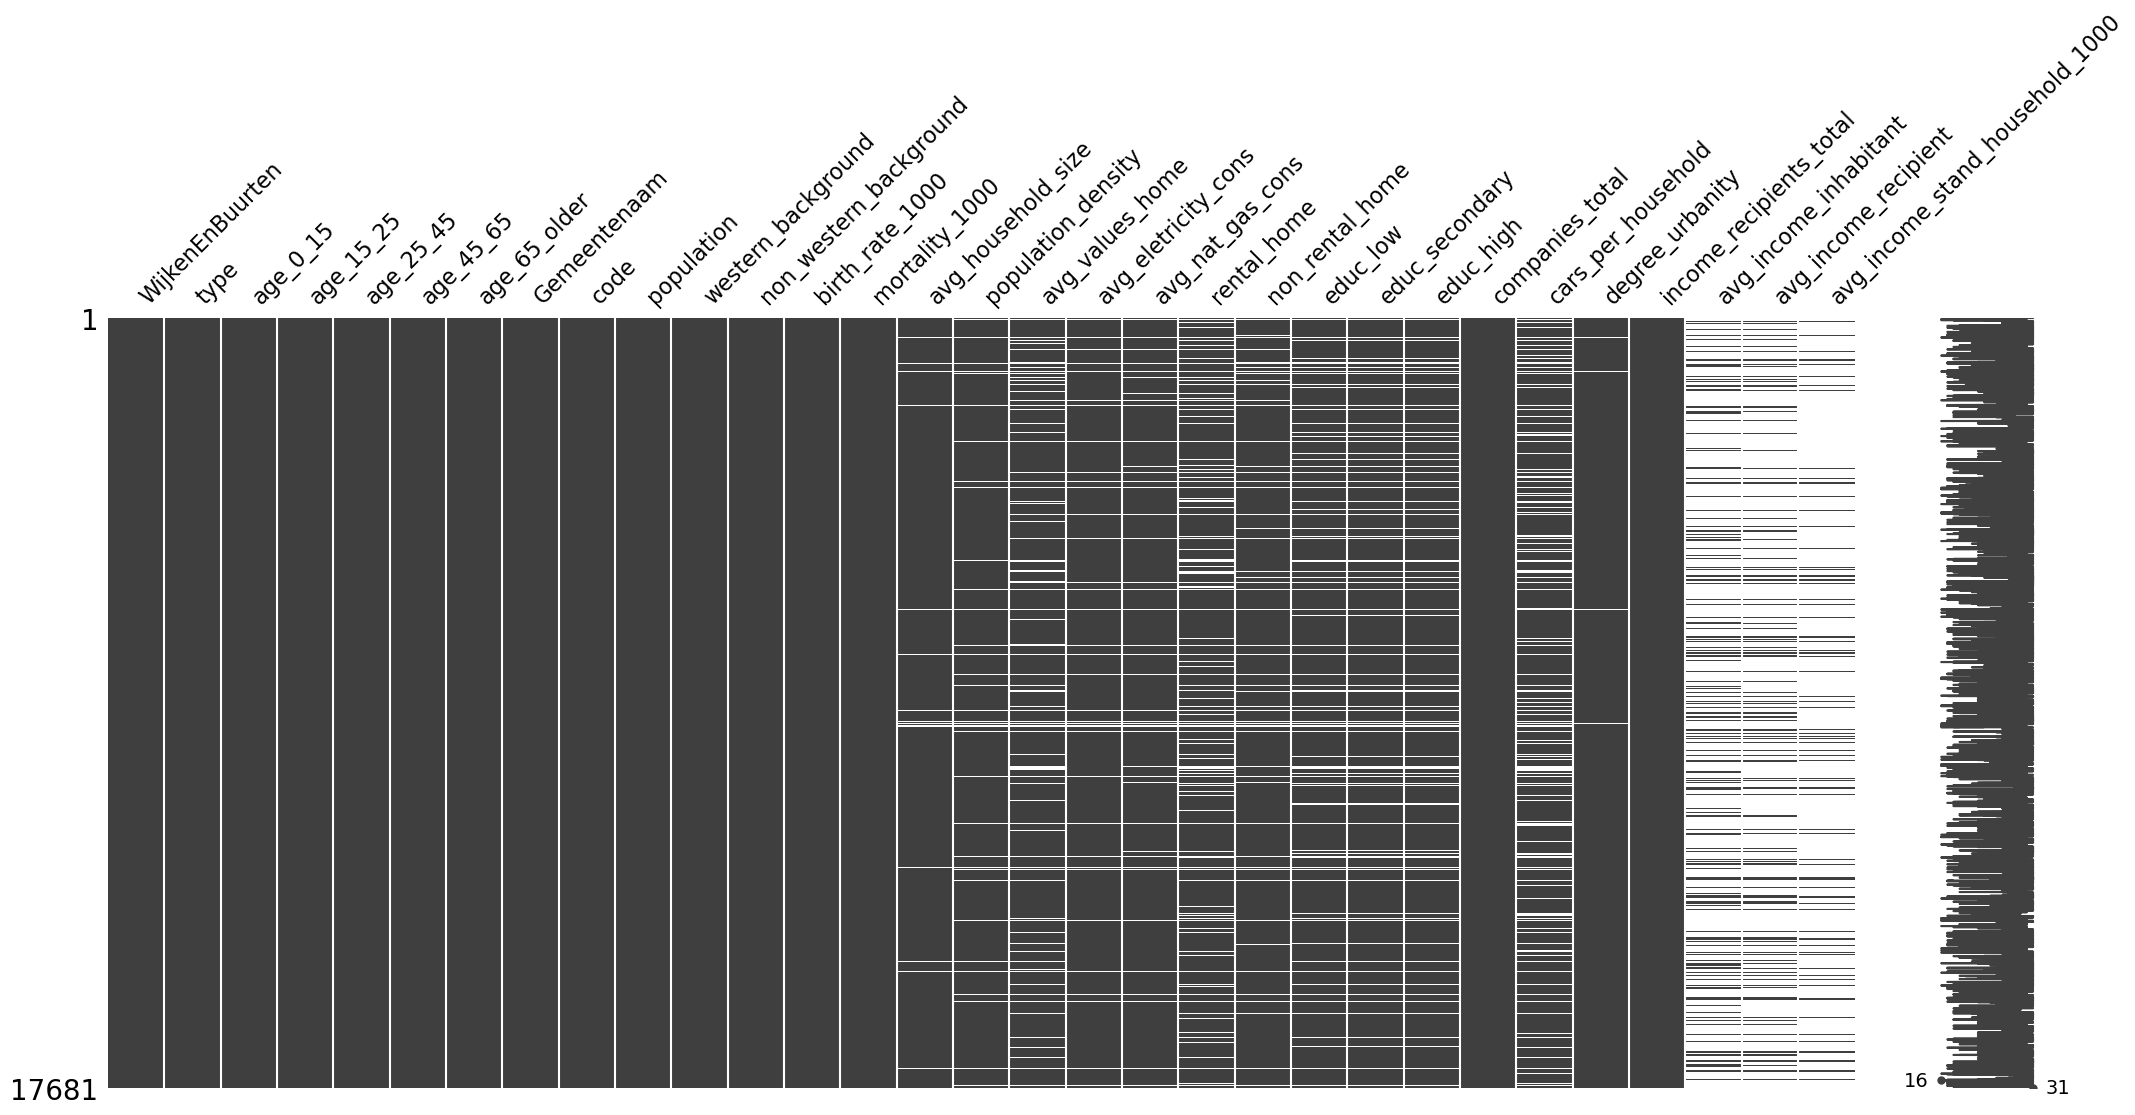

In [8]:
# Visualise missing values in the columns
plt.figure(figsize=(8, 6))
msno.matrix(filtered_se_data_21)
plt.show()

In [9]:
# Check number of missing values per column 
missing_values = filtered_se_data_21.isnull().sum()
print(missing_values)

WijkenEnBuurten                        0
type                                   0
age_0_15                               0
age_15_25                              0
age_25_45                              0
age_45_65                              0
age_65_older                           0
Gemeentenaam                           0
code                                   0
population                             0
western_background                     0
non_western_background                 0
birth_rate_1000                        0
mortality_1000                         0
avg_household_size                   373
population_density                   716
avg_values_home                     1989
avg_eletricity_cons                  941
avg_nat_gas_cons                    1011
rental_home                         2828
non_rental_home                     1285
educ_low                            2164
educ_secondary                      2158
educ_high                           2162
companies_total 

In [10]:
# Calculate average age based on weighted category by the midpoint

age_columns = ['age_0_15', 'age_15_25', 'age_25_45', 'age_45_65', 'age_65_older']
filtered_se_data_21.drop('population', axis=1, inplace=True) # Delete current population column, the given column had errors only 8686536 people for the Netherlands 
filtered_se_data_21['population'] = filtered_se_data_21[age_columns].sum(axis=1) # add new column based on age groups

weights = [7.5, 20, 35, 55, 75] # Weights based on midpoints 
filtered_se_data_21['average_age'] = filtered_se_data_21[age_columns].mul(weights).sum(axis=1) / filtered_se_data_21[age_columns].sum(axis=1)

# Drop old columns
filtered_se_data_21 = filtered_se_data_21.drop(columns=age_columns)

# Create new columns for background based on their proprotions of total population 
filtered_se_data_21['western_percentage'] = (filtered_se_data_21['western_background'] / filtered_se_data_21['population']) * 100
filtered_se_data_21['non_western_percentage'] = (filtered_se_data_21['non_western_background'] / filtered_se_data_21['population']) * 100

# Remove old columns
filtered_se_data_21 = filtered_se_data_21.drop(['western_background', 'non_western_background'], axis=1)

# Create a single column of percentage of people with higher education 
filtered_se_data_21['higher_educ'] = (filtered_se_data_21['educ_high'] / filtered_se_data_21['population']) * 100
filtered_se_data_21 = filtered_se_data_21.drop(['educ_low', 'educ_secondary', 'educ_high'], axis=1)

filtered_se_data_21.head()

WijkenEnBuurten        type  \
0                Nederland  Land         
1              Aa en Hunze  Gemeente     
2            Wijk 00 Annen  Wijk         
3                    Annen  Buurt        
4  Verspreide huizen Annen  Buurt        

                               Gemeentenaam        code  birth_rate_1000  \
0  Nederland                                 NL00                     10   
1  Aa en Hunze                               GM1680                    8   
2  Aa en Hunze                               WK168000                  9   
3  Aa en Hunze                               BU16800000               10   
4  Aa en Hunze                               BU16800009                6   

   mortality_1000  avg_household_size  population_density  avg_values_home  \
0              10                 2.1               519.0            290.0   
1              11                 2.2                92.0            273.0   
2               8                 2.3               245.0            272.0   
3               8                 2.3              1364.0            263.0   
4               6                 2.3                13.0            487.0   

   avg_eletricity_cons  ...  degree_urbanity  income_recipients_total  \
0               2810.0  ...              2.0                 13946000   
1               3160.0  ...              5.0                    20900   
2               3030.0  ...              5.0                     3000   
3               2970.0  ...              5.0                     2800   
4               4620.0  ...              5.0                      100   

   avg_income_inhabitant  avg_income_recipient  \
0                   29.2                  35.8   
1                   29.7                  35.3   
2                   30.9                  37.1   
3                   30.2                  36.4   
4                    NaN                   NaN   

   avg_income_stand_household_1000  population  average_age  \
0                             33.5    17475415    42.326804   
1                             35.1       25399    46.980098   
2                              NaN        3595    46.279555   
3                              NaN        3425    46.102190   
4                              NaN         150    51.916667   

   western_percentage  non_western_percentage  higher_educ  
0           10.636257               14.003547    24.123376  
1            4.181267                2.433167    23.504862  
2            3.337969                2.086231    24.200278  
3            3.357664                2.043796    23.941606  
4            3.333333                0.000000    33.333333  

[5 rows x 25 columns]

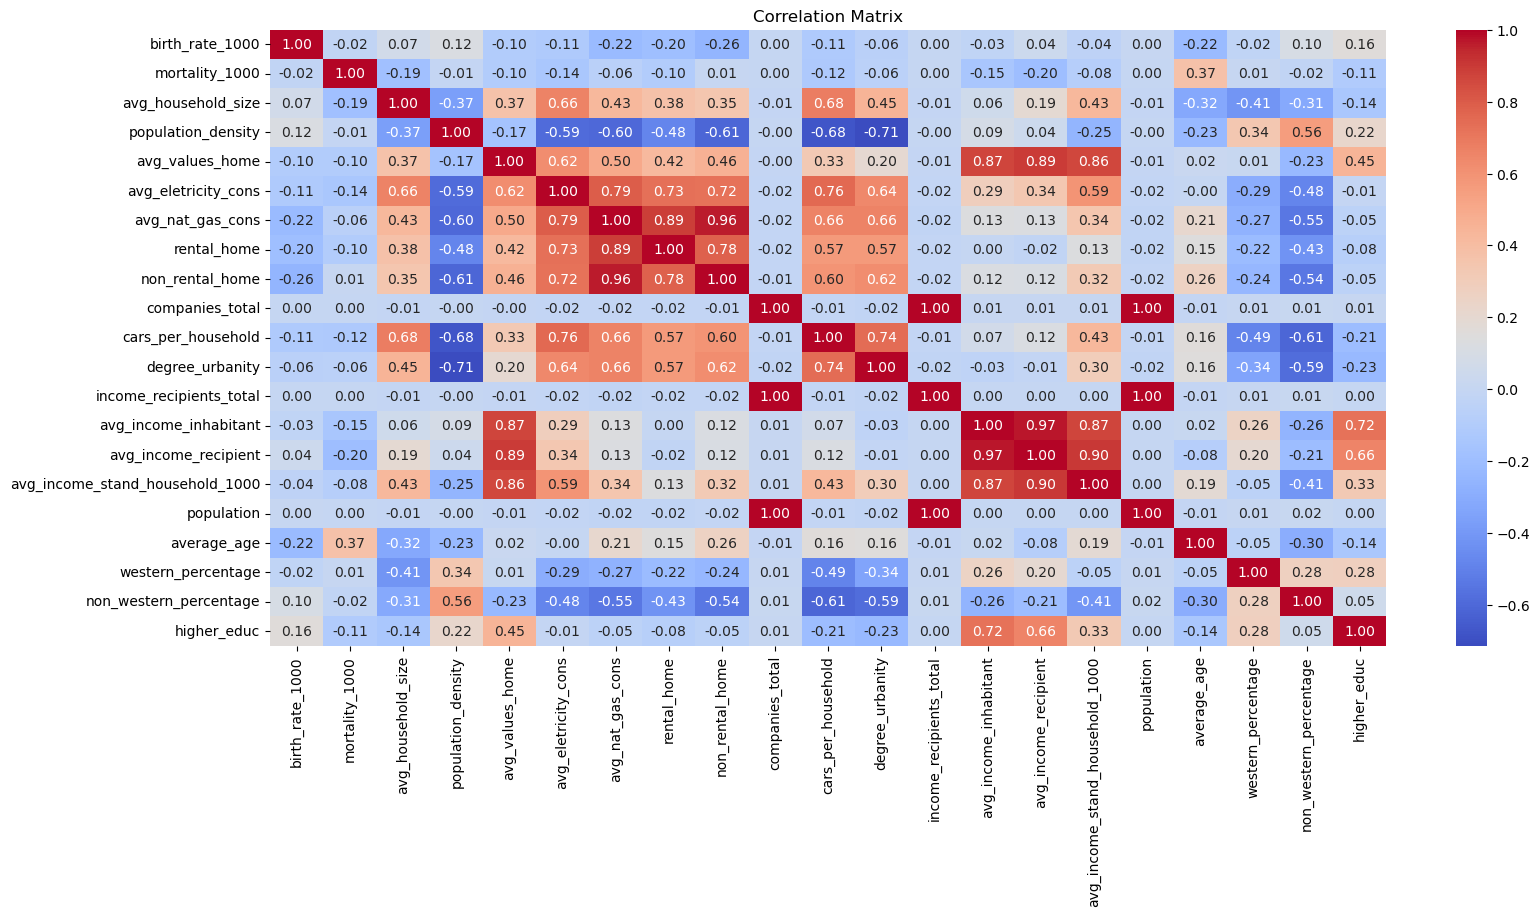

In [11]:
# calculate the correlation matrix
numeric_columns = filtered_se_data_21.select_dtypes(include=[np.number]).columns
correlation_matrix = filtered_se_data_21[numeric_columns].corr()

# create a heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [12]:
# preprocess the cbs '20 data 
rename_dict = {'Gemeentenaam_1': 'Gemeentenaam',
               'Codering_3': 'code',
               'GemiddeldInkomenPerInwoner_72': 'avg_income_inhabitant'
}

columns_to_keep = ['WijkenEnBuurten']  # columns not to be changed but included

# # rename and filter columns
filtered_se_data_20 = se_data_20.copy()
filtered_se_data_20 = filtered_se_data_20.rename(columns=rename_dict)  # rename specified columns
filtered_se_data_20 = filtered_se_data_20[list(columns_to_keep) + list(rename_dict.values())]

# the majority of income data missing, but available in cbs '20 data hence imputed into the '21
filtered_se_data_21['avg_income_inhabitant'] = filtered_se_data_21['avg_income_inhabitant'].mask(filtered_se_data_21['avg_income_inhabitant'].isnull())  
filtered_se_data_21['avg_income_inhabitant'] = filtered_se_data_21['avg_income_inhabitant'].combine_first(filtered_se_data_21['code'].map(filtered_se_data_20.set_index('code')['avg_income_inhabitant']))
filtered_se_data_21.head()

WijkenEnBuurten        type  \
0                Nederland  Land         
1              Aa en Hunze  Gemeente     
2            Wijk 00 Annen  Wijk         
3                    Annen  Buurt        
4  Verspreide huizen Annen  Buurt        

                               Gemeentenaam        code  birth_rate_1000  \
0  Nederland                                 NL00                     10   
1  Aa en Hunze                               GM1680                    8   
2  Aa en Hunze                               WK168000                  9   
3  Aa en Hunze                               BU16800000               10   
4  Aa en Hunze                               BU16800009                6   

   mortality_1000  avg_household_size  population_density  avg_values_home  \
0              10                 2.1               519.0            290.0   
1              11                 2.2                92.0            273.0   
2               8                 2.3               245.0            272.0   
3               8                 2.3              1364.0            263.0   
4               6                 2.3                13.0            487.0   

   avg_eletricity_cons  ...  degree_urbanity  income_recipients_total  \
0               2810.0  ...              2.0                 13946000   
1               3160.0  ...              5.0                    20900   
2               3030.0  ...              5.0                     3000   
3               2970.0  ...              5.0                     2800   
4               4620.0  ...              5.0                      100   

   avg_income_inhabitant  avg_income_recipient  \
0                   29.2                  35.8   
1                   29.7                  35.3   
2                   30.9                  37.1   
3                   30.2                  36.4   
4                   43.1                   NaN   

   avg_income_stand_household_1000  population  average_age  \
0                             33.5    17475415    42.326804   
1                             35.1       25399    46.980098   
2                              NaN        3595    46.279555   
3                              NaN        3425    46.102190   
4                              NaN         150    51.916667   

   western_percentage  non_western_percentage  higher_educ  
0           10.636257               14.003547    24.123376  
1            4.181267                2.433167    23.504862  
2            3.337969                2.086231    24.200278  
3            3.357664                2.043796    23.941606  
4            3.333333                0.000000    33.333333  

[5 rows x 25 columns]

In [13]:
# check the missigness after imputation
filtered_se_data_21['avg_income_inhabitant'].isna().sum()

3266

In [14]:
# filter the buurt dataset with polygons to relevant column that is to be merged onto cbs 
filtered_neighborhood_gdf = neighborhood_gdf.copy()
filtered_neighborhood_gdf = filtered_neighborhood_gdf[["BU_CODE", "BU_NAAM", "WK_CODE", "GM_CODE", "GM_NAAM", "geometry"]] #filter out irrelevant features

# filter the wijk data with polygons to be merged onto cbs 
filtered_district_gdf = district_gdf.copy()
filtered_district_gdf = filtered_district_gdf[["WK_CODE", "WK_NAAM", "GM_CODE", "GM_NAAM", "geometry"]] #filter out irrelevant features

filtered_district_gdf.head()

WK_CODE WK_NAAM GM_CODE        GM_NAAM  \
0  WK040099     NaN  GM0400     Den Helder   
1  WK057599     NaN  GM0575      Noordwijk   
2  WK031399     NaN  GM0313     Bunschoten   
3  WK037399     NaN  GM0373   Bergen (NH.)   
4  WK051899     NaN  GM0518  's-Gravenhage   

                                            geometry  
0  MULTIPOLYGON (((123759.939 553480.122, 124000....  
1  POLYGON ((94097.396 482632.130, 94098.779 4826...  
2  POLYGON ((151869.700 477630.813, 153516.847 47...  
3  POLYGON ((104934.802 530182.861, 104945.814 53...  
4  POLYGON ((80651.769 460685.198, 80727.363 4606...

## Merge data

### Buurt level

In [15]:
# Merge BURT data with CBS data and aggregate them on the buurt level
merged_df = pd.merge(neighborhood_gdf, filtered_se_data_21, left_on='BU_CODE', right_on='code', how='left')
buurt_cbs_vgvi_merged = gpd.GeoDataFrame(merged_df)

# Join the merged data with VGVI data based on spatial containment
joined_data = gpd.sjoin(buurt_cbs_vgvi_merged, vgvi_data, how='left', op='contains')
vgvi_by_buurt = joined_data.groupby('BU_CODE')['VGVI'].mean().reset_index()

# Merge the buurt-CBS data with the aggregated VGVI data
buurt_cbs_vgvi_merged = buurt_cbs_vgvi_merged.merge(vgvi_by_buurt, on='BU_CODE', how='left')

In [16]:
# add count columns per each buurt 
bu_code_counts = joined_data.groupby('BU_CODE').size().reset_index(name='BU_CODE_COUNT')
buurt_cbs_vgvi_merged = bu_code_counts.merge(buurt_cbs_vgvi_merged, on='BU_CODE', how='inner')
buurt_cbs_vgvi_merged.head(3)

BU_CODE  BU_CODE_COUNT           BU_NAAM   WK_CODE GM_CODE    GM_NAAM  \
0  BU00140000            193  Binnenstad-Noord  WK001400  GM0014  Groningen   
1  BU00140001            338   Binnenstad-Zuid  WK001400  GM0014  Groningen   
2  BU00140002            217   Binnenstad-Oost  WK001400  GM0014  Groningen   

   IND_WBI  H2O POSTCODE  DEK_PERC  ...  income_recipients_total  \
0        1  NEE     9712         1  ...                   3800.0   
1        1  NEE     9711         1  ...                   5500.0   
2        1  NEE     9711         3  ...                   3500.0   

   avg_income_inhabitant  avg_income_recipient  \
0                   22.1                  24.4   
1                   22.7                  24.9   
2                   21.5                  23.7   

   avg_income_stand_household_1000  population  average_age  \
0                             19.8      4505.0    31.958935   
1                             19.4      6410.0    32.583853   
2                             18.9      4170.0    33.603118   

   western_percentage  non_western_percentage  higher_educ      VGVI  
0           18.756937               10.432852    41.509434  0.095778  
1           18.096724               11.778471    45.709828  0.131716  
2           17.985612               14.388489    44.124700  0.154358  

[3 rows x 71 columns]

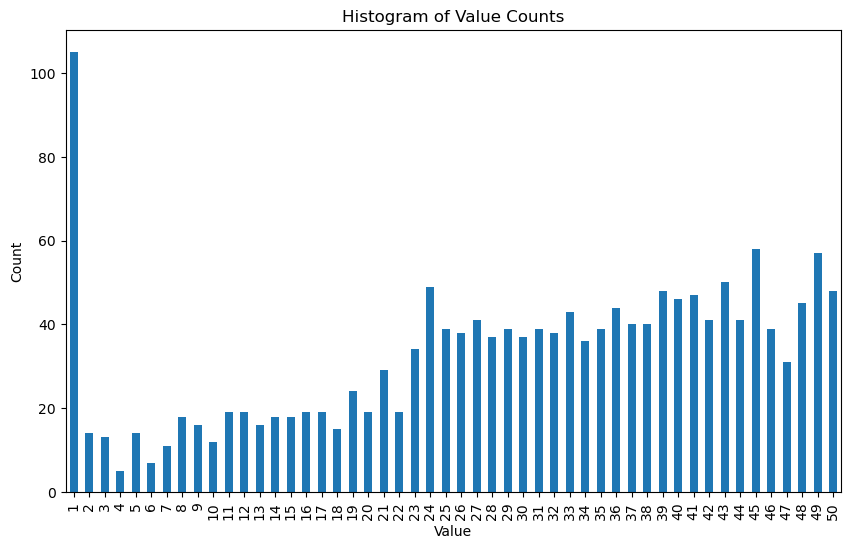

In [17]:
# Check the number of neighbourhoods with counts of points 
value_counts = bu_code_counts['BU_CODE_COUNT'].value_counts().sort_index()
limited_value_counts = value_counts[:50]
plt.figure(figsize=(10, 6)) 
limited_value_counts.plot(kind='bar')

plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of Value Counts')

plt.show()

In [18]:
# Remove neighbourhoods with only one point 
buurt_cbs_vgvi_merged = buurt_cbs_vgvi_merged[buurt_cbs_vgvi_merged['BU_CODE_COUNT'] >= 2]
len(buurt_cbs_vgvi_merged[buurt_cbs_vgvi_merged['BU_CODE_COUNT'] <= 1])

0

In [42]:
# Remove neighbourhoods with only one point from non-aggregated version, too
joined_data_buurt = joined_data.merge(buurt_cbs_vgvi_merged[['BU_CODE', 'BU_CODE_COUNT']], on='BU_CODE', how='left').copy()
joined_data_buurt = joined_data_buurt[joined_data_buurt['BU_CODE_COUNT'] >= 2]
len(joined_data_buurt[joined_data_buurt['BU_CODE_COUNT'] <= 1])

0

In [43]:
# Save the file
joined_data_buurt = joined_data_buurt[['BU_CODE', 'geometry', 'VGVI', 'population']]
joined_data_buurt.to_file('data_collection/cleaned_data/joined_data_buurt.gpkg', driver='GPKG', options=['COMPRESS=DEFLATE'])

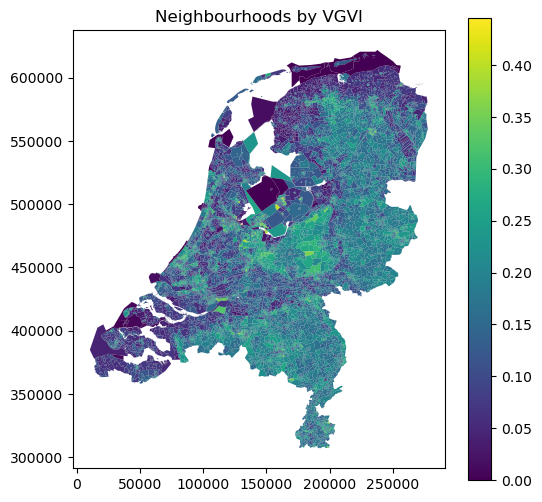

In [43]:
# Plot VGVI on a neighbourhood-level
vgvi_buurt = buurt_cbs_vgvi_merged[~buurt_cbs_vgvi_merged['VGVI'].isnull()]
vgvi_buurt = gpd.GeoDataFrame(vgvi_buurt, geometry='geometry')
vgvi_buurt = vgvi_buurt.to_crs(epsg=28992)

fig, ax = plt.subplots(figsize=(6, 6))
vgvi_buurt.plot(column='VGVI', cmap='viridis', linewidth=0.01, edgecolor='black', legend=True, ax=ax)

# Uncomment the following line to add a basemap using contextily
# contextily.add_basemap(ax, crs=wijk_cbs_joined_filtered.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")

plt.title('Neighbourhoods by VGVI')
plt.show()

In [25]:
# save the aggregated file
buurt_cbs_vgvi_merged = gpd.GeoDataFrame(buurt_cbs_vgvi_merged)
buurt_cbs_vgvi_merged.to_file('data_collection/cleaned_data/buurt_cbs_vgvi_merged_V2.gpkg', driver="GPKG")

# save the not-aggregated file
joined_data_buurt = gpd.GeoDataFrame(joined_data_buurt)
joined_data_buurt.to_file('data_collection/cleaned_data/joined_data_buurt.gpkg', driver="GPKG")

### Wijk level

In [47]:
# merge Wijk data with CBS data and aggregate them on the wjik level
joined_data_wijk = gpd.sjoin(filtered_district_gdf, vgvi_data, how='left', op='contains')
vgvi_by_wijk = joined_data_wijk.groupby('WK_CODE')['VGVI'].mean().reset_index()

wijk_cbs_joined = filtered_district_gdf.merge(vgvi_by_wijk, on='WK_CODE', how='left')
wijk_cbs_joined

WK_CODE               WK_NAAM GM_CODE            GM_NAAM  \
0     WK040099                   NaN  GM0400         Den Helder   
1     WK057599                   NaN  GM0575          Noordwijk   
2     WK031399                   NaN  GM0313         Bunschoten   
3     WK037399                   NaN  GM0373       Bergen (NH.)   
4     WK051899                   NaN  GM0518      's-Gravenhage   
...        ...                   ...     ...                ...   
3418  WK150700  Wijk 00 Griendtsveen  GM1507  Horst aan de Maas   
3419  WK173105       Wijk 05 Drijber  GM1731     Midden-Drenthe   
3420  WK035625            Rijnhuizen  GM0356         Nieuwegein   
3421  WK194011  Wijk 11 Echtenerbrug  GM1940   De Fryske Marren   
3422  WK008501             Appelscha  GM0085   Ooststellingwerf   

                                               geometry      VGVI  
0     MULTIPOLYGON (((123759.939 553480.122, 124000....  0.000000  
1     POLYGON ((94097.396 482632.130, 94098.779 4826...       NaN  
2     POLYGON ((151869.700 477630.813, 153516.847 47...       NaN  
3     POLYGON ((104934.802 530182.861, 104945.814 53...       NaN  
4     POLYGON ((80651.769 460685.198, 80727.363 4606...  0.000195  
...                                                 ...       ...  
3418  POLYGON ((189256.503 383688.114, 189173.815 38...  0.218385  
3419  POLYGON ((233608.703 535484.125, 233745.500 53...  0.189714  
3420  POLYGON ((135344.808 450343.862, 135390.348 45...  0.277925  
3421  POLYGON ((183539.502 542231.974, 183591.268 54...  0.063275  
3422  POLYGON ((218800.307 553583.574, 218951.642 55...  0.213096  

[3423 rows x 6 columns]

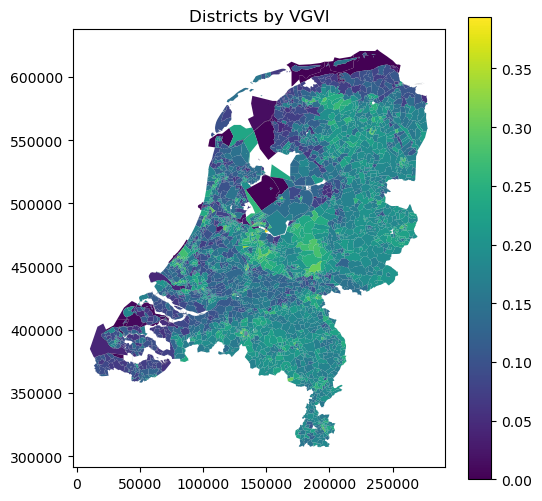

In [48]:
# Plot VGVI on a district-level
vgvi_wijk = wijk_cbs_joined[~buurt_cbs_vgvi_merged['VGVI'].isnull()]
vgvi_wijk = gpd.GeoDataFrame(vgvi_wijk, geometry='geometry')
vgvi_wijk = vgvi_wijk.to_crs(epsg=28992)

fig, ax = plt.subplots(figsize=(6, 6))
vgvi_wijk.plot(column='VGVI', cmap='viridis', linewidth=0.01, edgecolor='black', legend=True, ax=ax)

# Uncomment the following line to add a basemap using contextily
# contextily.add_basemap(ax, crs=filtered_data.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")

plt.title('Districts by VGVI')
plt.show()

# Spatial autocorrelation

Spatial autocorrelation analyses involve the following: 
- **Moran's I Statistic**
- **LISA**
- **GI Algorithm**

In [56]:
# load cleaned buurt-aggregated dataset
buurt_cbs_vgvi_merged = gpd.read_file('data_collection/cleaned_data/buurt_cbs_vgvi_merged_V2.gpkg')
buurt_cbs_vgvi_merged.head(3)

BU_CODE  BU_CODE_COUNT           BU_NAAM   WK_CODE GM_CODE    GM_NAAM  \
0  BU00140000            193  Binnenstad-Noord  WK001400  GM0014  Groningen   
1  BU00140001            338   Binnenstad-Zuid  WK001400  GM0014  Groningen   
2  BU00140002            217   Binnenstad-Oost  WK001400  GM0014  Groningen   

    WijkenEnBuurten        type                              Gemeentenaam  \
0  Binnenstad-Noord  Buurt       Groningen                                  
1   Binnenstad-Zuid  Buurt       Groningen                                  
2   Binnenstad-Oost  Buurt       Groningen                                  

         code  birth_rate_1000  mortality_1000  avg_household_size  \
0  BU00140000              4.0             2.0                 1.2   
1  BU00140001              2.0             4.0                 1.2   
2  BU00140002              5.0             4.0                 1.3   

   population_density  avg_values_home  avg_eletricity_cons  avg_nat_gas_cons  \
0             12192.0            222.0               2170.0            1250.0   
1             11651.0            225.0               2100.0            1170.0   
2             15441.0            191.0               1890.0             980.0   

   rental_home  non_rental_home  companies_total  cars_per_household  \
0       1190.0           1700.0            975.0                 0.2   
1       1110.0           1600.0           1620.0                 0.2   
2        950.0           1210.0            590.0                 0.2   

   degree_urbanity  income_recipients_total  avg_income_inhabitant  \
0              1.0                   3800.0                   22.1   
1              1.0                   5500.0                   22.7   
2              1.0                   3500.0                   21.5   

   avg_income_recipient  avg_income_stand_household_1000  population  \
0                  24.4                             19.8      4505.0   
1                  24.9                             19.4      6410.0   
2                  23.7                             18.9      4170.0   

   average_age  western_percentage  non_western_percentage  higher_educ  \
0    31.958935           18.756937               10.432852    41.509434   
1    32.583853           18.096724               11.778471    45.709828   
2    33.603118           17.985612               14.388489    44.124700   

       VGVI                                           geometry  
0  0.095778  POLYGON ((233836.216 582380.178, 233892.194 58...  
1  0.131716  POLYGON ((233933.980 581951.340, 233973.600 58...  
2  0.154358  POLYGON ((233998.790 582526.540, 234278.520 58...

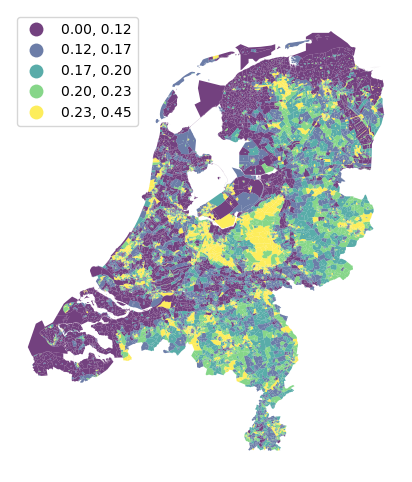

In [58]:
# Filter to only relevant fields for spatial autocorrelation analysis
variable_names = [
    "VGVI",
    "geometry"
]

autocorrelation_data = buurt_cbs_vgvi_merged[variable_names].copy()
autocorrelation_data.dropna(inplace=True)  # Remove rows with empty fields

f, ax = plt.subplots(1, figsize=(6, 6))
autocorrelation_data.plot(
    column="VGVI",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)

# contextily.add_basemap(ax, crs=buurt_cbs_vgvi_merged.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")
ax.set_axis_off()

In [59]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(autocorrelation_data, k=8)
# Row-standardization
w.transform = "R"

autocorrelation_data["VGVI_lag"] = weights.spatial_lag.lag_spatial(
    w, autocorrelation_data["VGVI"]
)

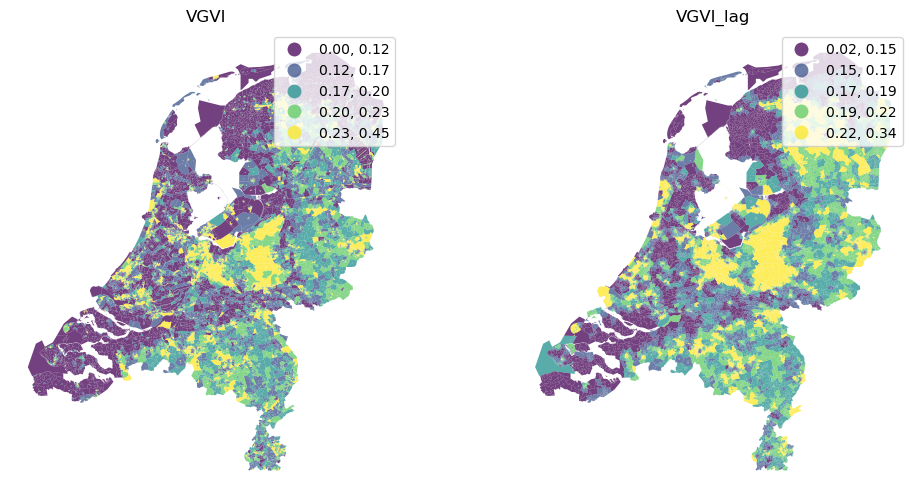

In [60]:
# create a plot for both VGVI and its lag model
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

autocorrelation_data.plot(
    column="VGVI",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("VGVI")
# contextily.add_basemap(ax, crs=autocorrelation_data.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")

autocorrelation_data.plot(
    column="VGVI_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("VGVI_lag")
# contextily.add_basemap(ax, crs=autocorrelation_data.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")

plt.show()

## Moran Statistic

In [61]:
autocorrelation_data["VGVI_std"] = autocorrelation_data["VGVI"] - autocorrelation_data["VGVI"].mean()
autocorrelation_data["VGVI_lag_std"] = weights.lag_spatial(
    w, autocorrelation_data["VGVI_std"]
)

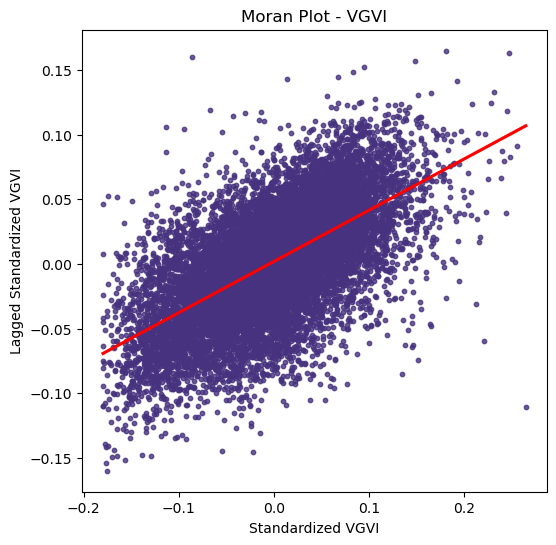

In [63]:
# Plot Moran's statistic
sns.set_palette("viridis")

f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="VGVI_std",
    y="VGVI_lag_std",
    ci=None,
    data=autocorrelation_data,
    scatter_kws={"s": 10},  # Adjust the marker size here
    line_kws={"color": "r"},
)
ax.set_xlabel("Standardized VGVI")
ax.set_ylabel("Lagged Standardized VGVI")
ax.set_title("Moran Plot - VGVI")

# plt.savefig("visualisation/moran_plot.png", dpi=300)
plt.show()

In [64]:
w.transform = "R"
moran = esda.moran.Moran(autocorrelation_data["VGVI"], w)
print("Moran's I:", moran.I)
print("p-value (p-sim):", moran.p_sim)

Moran's I: 0.3959005711147371
p-value (p-sim): 0.001


## LISA

<Axes: ylabel='Density'>

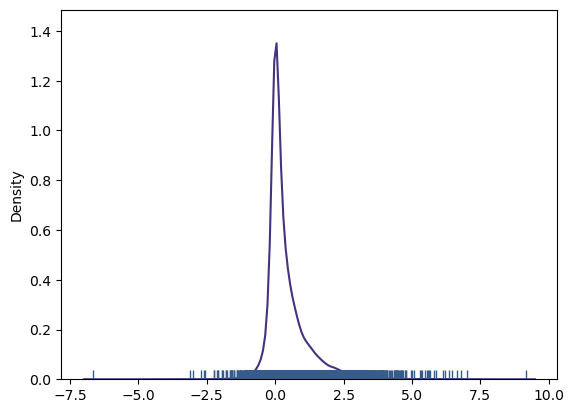

In [65]:
lisa = esda.moran.Moran_Local(autocorrelation_data["VGVI"], w)
# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax)

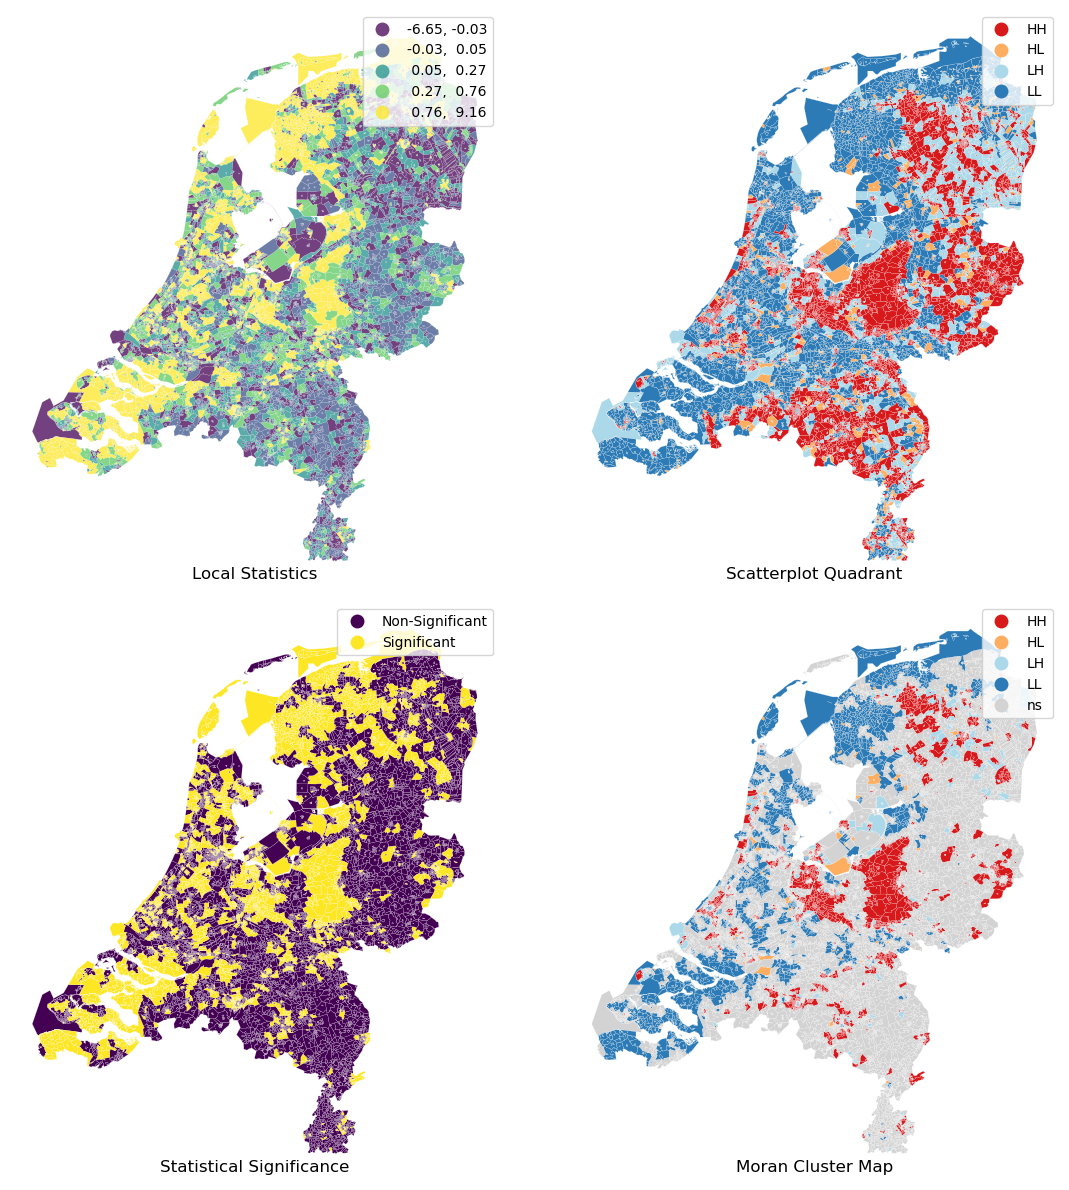

In [73]:
# the plots have been adapted from https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html

# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
autocorrelation_data.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, autocorrelation_data, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=autocorrelation_data.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `autocorrelation_data` on the fly
autocorrelation_data.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="viridis",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, autocorrelation_data, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

In [ ]:
# Break observations into significant or not
autocorrelation_data['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
autocorrelation_data['quadrant'] = lisa.q

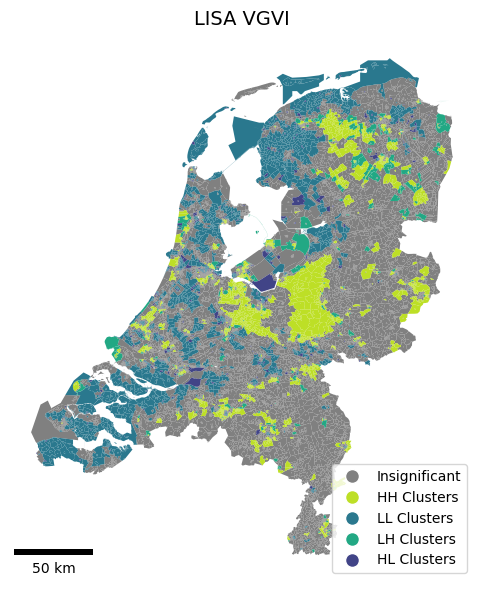

In [70]:
# Setup the figure and axis
fig, ax = plt.subplots(1, figsize=(6, 6))

# Plot insignificant clusters
insignificant_clusters = autocorrelation_data.loc[autocorrelation_data['significant'] == False, 'geometry']
insignificant_clusters.plot(ax=ax, color='gray')

# Plot significant clusters in different quadrants
hh_clusters = autocorrelation_data.loc[(autocorrelation_data['quadrant'] == 1) & (autocorrelation_data['significant'] == True), 'geometry']
hh_clusters.plot(ax=ax, color=cm.viridis(0.9))

ll_clusters = autocorrelation_data.loc[(autocorrelation_data['quadrant'] == 3) & (autocorrelation_data['significant'] == True), 'geometry']
ll_clusters.plot(ax=ax, color=cm.viridis(0.4))

lh_clusters = autocorrelation_data.loc[(autocorrelation_data['quadrant'] == 2) & (autocorrelation_data['significant'] == True), 'geometry']
lh_clusters.plot(ax=ax, color=cm.viridis(0.6))

hl_clusters = autocorrelation_data.loc[(autocorrelation_data['quadrant'] == 4) & (autocorrelation_data['significant'] == True), 'geometry']
hl_clusters.plot(ax=ax, color=cm.viridis(0.2))

# Create a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Insignificant', markerfacecolor='gray', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='HH Clusters', markerfacecolor=cm.viridis(0.9), markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='LL Clusters', markerfacecolor=cm.viridis(0.4), markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='LH Clusters', markerfacecolor=cm.viridis(0.6), markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='HL Clusters', markerfacecolor=cm.viridis(0.2), markersize=10)
]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='lower right')

# Add scale bar to the plot
ax.add_artist(ScaleBar(1, location="lower left"))

# Set plot title
ax.set_title('LISA VGVI', loc='center', fontsize=14)

# Style and draw
ax.set_axis_off()
plt.tight_layout()
plt.show()

## GI* algorithm

In [71]:
# replicate the analysis using  Gi
go_i = esda.getisord.G_Local(autocorrelation_data["VGVI"], w)
go_i_star = esda.getisord.G_Local(autocorrelation_data["VGVI"], w, star=True)

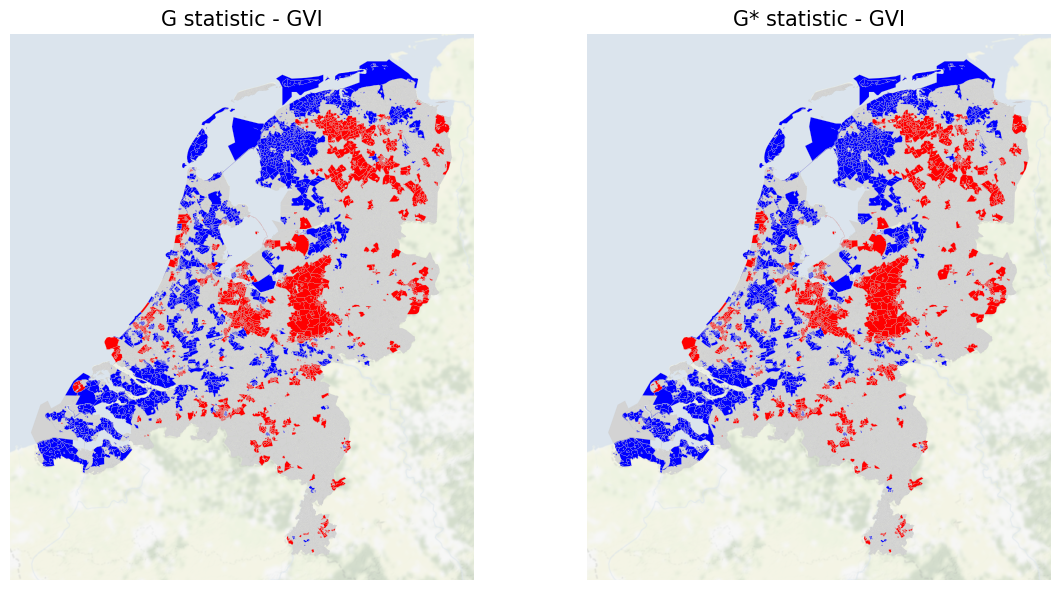

In [75]:
def g_map(g, autocorrelation_data, ax):
    """
    # the function has been adapted from https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    autocorrelation_data     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec = "0.8"

    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = autocorrelation_data.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = autocorrelation_data.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = autocorrelation_data.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(ax, crs=autocorrelation_data.crs, source=contextily.providers.Stamen.TerrainBackground, alpha=0.35, attribution="")
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"G{st} statistic - GVI", size=15)
    # Remove axis for aesthetics
    ax.set_axis_off()
    return ax

# Set up figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics
for g, ax in zip([go_i, go_i_star], axs.flatten()):
    # Generate the statistic's map
    ax = g_map(g, autocorrelation_data, ax)
# Tight layout to minimise blank spaces
f.tight_layout()
# Render
plt.show()

# Modelling 
Modelling process involves the following: 
- **Ordinary least squares (OLS)**
- **Geographically weighted regression (GWR)**
- **Multiscale Geographically Weighted Regression (MGWR)**
- **Gini index & Weighted Gini index**

## OLS

In [77]:
# load cleaned dataset
buurt_cbs_vgvi_merged = gpd.read_file('data_collection/cleaned_data/buurt_cbs_vgvi_merged_V2.gpkg')

In [87]:
# perform OLS first to get an idea of the data
# Define the variable names to filter
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "non_western_percentage",
    "avg_values_home",
    "VGVI",
    "geometry"
]


modelling_data = buurt_cbs_vgvi_merged.copy()
modelling_data = modelling_data[variable_names]
modelling_data.dropna(inplace=True)
modelling_data.reset_index(drop=True, inplace=True)
modelling_data.head()

avg_income_inhabitant  higher_educ  average_age  non_western_percentage  \
0                   22.1    41.509434    31.958935               10.432852   
1                   22.7    45.709828    32.583853               11.778471   
2                   21.5    44.124700    33.603118               14.388489   
3                   24.8    45.481050    34.569971                9.620991   
4                   26.9    45.535714    35.232143               10.892857   

   avg_values_home      VGVI  \
0            222.0  0.095778   
1            225.0  0.131716   
2            191.0  0.154358   
3            226.0  0.123234   
4            224.0  0.143314   

                                            geometry  
0  POLYGON ((233836.216 582380.178, 233892.194 58...  
1  POLYGON ((233933.980 581951.340, 233973.600 58...  
2  POLYGON ((233998.790 582526.540, 234278.520 58...  
3  POLYGON ((233187.240 581984.190, 233217.790 58...  
4  POLYGON ((234098.513 582873.654, 233828.947 58...

In [88]:
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "non_western_percentage",
    "avg_values_home"
]

# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    modelling_data[["VGVI"]].values,
    # Independent variables
    modelling_data[variable_names].values,
    # Dependent variable name
    name_y="VGVI",
    # Independent variable name
    name_x=variable_names,
)
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :        VGVI                Number of Observations:       10221
Mean dependent var  :      0.1829                Number of Variables   :           6
S.D. dependent var  :      0.0595                Degrees of Freedom    :       10215
R-squared           :      0.0894
Adjusted R-squared  :      0.0889
Sum squared residual:      32.927                F-statistic           :    200.5522
Sigma-square        :       0.003                Prob(F-statistic)     :  1.433e-204
S.E. of regression  :       0.057                Log likelihood        :   14820.530
Sigma-square ML     :       0.003                Akaike info criterion :  -29629.059
S.E of regression ML:      0.0568                Schwarz criterion     :  -29585.666

-----------------------------------------------------------------------------

## GWR (Adaptive kernel)

In [89]:
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "non_western_percentage",
    "avg_values_home"
]

g_y = modelling_data['VGVI'].values.reshape((-1, 1)).astype(float)
g_X = modelling_data[variable_names].values.astype(float)

u = modelling_data['geometry'].centroid.x
v = modelling_data['geometry'].centroid.y

g_X = (g_X - g_X.mean(axis = 0)) / g_X.std(axis = 0)
g_y = g_y.reshape((-1,1))
g_y = (g_y - g_y.mean(axis = 0)) / g_y.std(axis = 0)

g_coords = list(zip(u, v))

bw = Sel_BW(g_coords, g_y, g_X).search(criterion='AICc')
np.float = float # avoid numpy updata issue with floats 
gwr_results = GWR(g_coords, g_y, g_X, bw, fixed = False).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                               10221
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           9307.340
Log-likelihood:                                                  -14024.418
AIC:                                                              28060.836
AICc:                                                             28062.847
BIC:                                                             -84999.580
R2:                                                                   0.089
Adj. R2:                                                              0.089

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

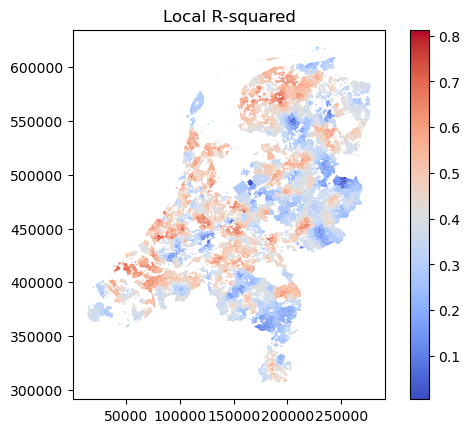

In [94]:
# plot the local R2 
local_r2 = gwr_results.localR2
modelling_data['local_r2'] = local_r2
modelling_data.plot(column='local_r2', cmap='coolwarm', legend=True)
plt.title('Local R-squared')
plt.show()

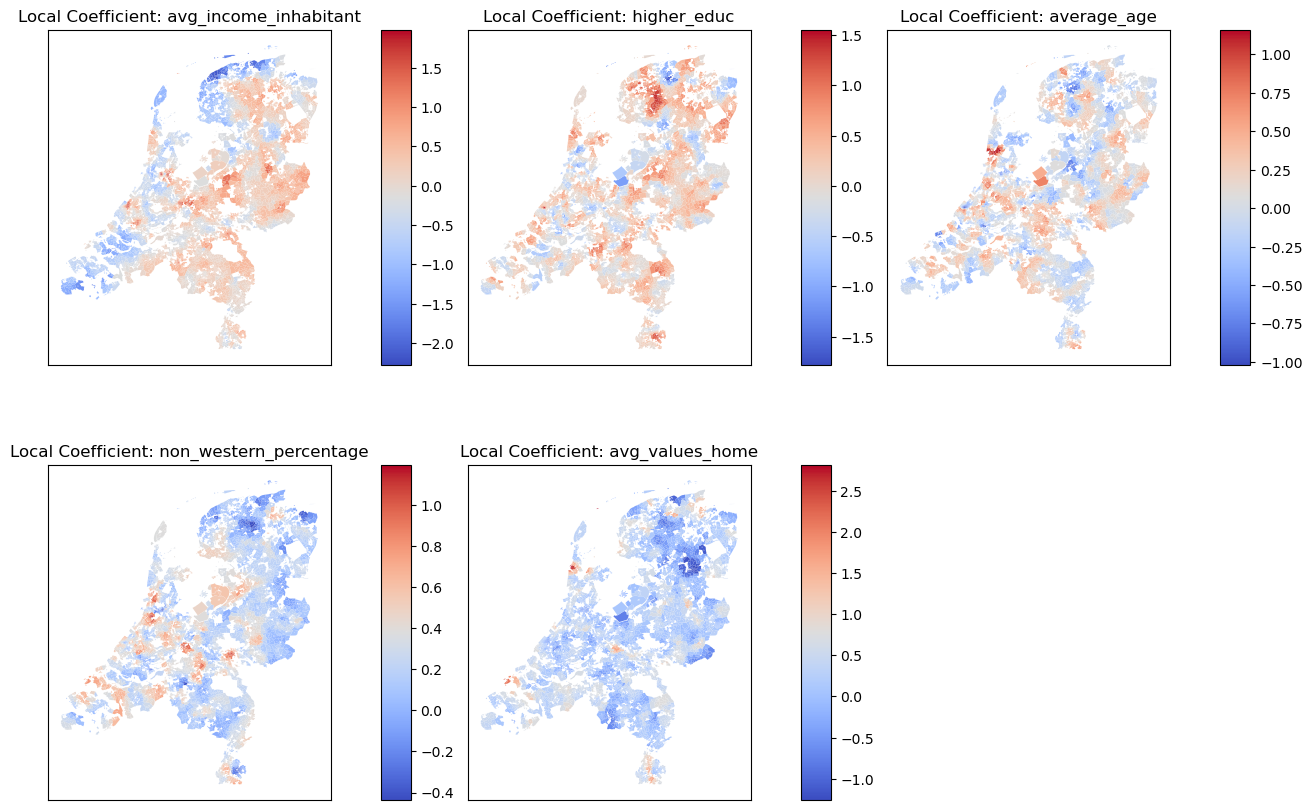

In [93]:
# numeber of rows selected for the plots 
num_variables = len(variable_names)
num_rows = 2
num_cols = math.ceil(num_variables / num_rows)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# flatten the axs array
axs = axs.flatten()

for i, coef_variable in enumerate(variable_names):
    local_coefficients = gwr_results.params[:, i]  # extract the local coefficients

    modelling_data['local_coefficients'] = local_coefficients
    
    subplot_index = i % (num_rows * num_cols)
    ax = axs[subplot_index]
    ax.set_title('Local Coefficient: {}'.format(coef_variable))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    modelling_data.plot(column='local_coefficients', cmap='coolwarm', legend=True, cax=fig.add_axes([ax.get_position().x1 + 0.02, ax.get_position().y0, 0.02, ax.get_position().height]), ax=ax)

    # remove empty plots 
for j in range(num_variables, num_rows * num_cols):
    axs[j].axis('off')

plt.show()

## MGWR 
### pysal/mgwr - slow computation won't run if RAM < 12GB

In [95]:
# # Using mgwr from a standard package, too slow, use the second approach below
# variable_names = [
#     "avg_income_inhabitant",
#     "higher_educ",
#     "average_age",
#     "non_western_percentage",
#     "avg_values_home"
# ]

# g_y = modelling_data['VGVI'].values.reshape((-1, 1)).astype(float)
# g_X = modelling_data[variable_names].values.astype(float)

# u = modelling_data['geometry'].centroid.x
# v = modelling_data['geometry'].centroid.y

# g_X = (g_X - g_X.mean(axis = 0)) / g_X.std(axis = 0)
# g_y = g_y.reshape((-1,1))
# g_y = (g_y - g_y.mean(axis = 0)) / g_y.std(axis = 0)

# g_coords = list(zip(u, v))

# mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi = True).search(criterion='AICc')
# mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()
# mgwr_results

### fastMGWR - fast computation

In [96]:
# first we preprocess the data into the required format for fastMGWR
variable_names = [
    "avg_income_inhabitant",
    "higher_educ",
    "average_age",
    "non_western_percentage",
    "avg_values_home"
]

g_y = modelling_data['VGVI'].values.reshape((-1, 1)).astype(float)
g_X = modelling_data[variable_names].values.astype(float)
u = modelling_data['geometry'].centroid.x
v = modelling_data['geometry'].centroid.y

# create a new df to store the data
mgwr_input = pd.DataFrame({
    "X-coord": u,
    "y-coord": v,
    "y": g_y.flatten()
})

# add the features to the df
for i, var_name in enumerate(variable_names):
    mgwr_input[var_name] = g_X[:, i]

# # save 
# mgwr_input.to_csv('input_mgwr.csv', index=False)

In [3]:
# run from anaconda prompt for faster implementation 
!fastgwr run -np 4 -data input_mgwr.csv -mgwr - chunks 10

In [104]:
# load the results 
fastmgwr_output = pd.read_csv('mgwr/fastgwr_rslt_V2.csv')
fastmgwr_output

index  residual  b_intercept  b_avg_income_inhabitant  b_higher_educ  \
0          0.0 -1.028234     0.311445                -0.136600       0.072481   
1          1.0 -0.543458     0.327819                -0.136575       0.072498   
2          2.0 -0.156543     0.280835                -0.136538       0.071859   
3          3.0 -0.780466     0.349135                -0.136637       0.073077   
4          4.0 -0.496615     0.361585                -0.136619       0.072484   
...        ...       ...          ...                      ...            ...   
10217  10217.0 -0.960131    -0.599147                -0.151869      -0.057306   
10218  10218.0  0.008813    -0.732928                -0.151903      -0.069020   
10219  10219.0  0.332395    -0.217857                -0.151929       0.041414   
10220  10220.0 -0.382014    -0.445728                -0.151593      -0.053463   
10221  10221.0 -1.006194    -0.503699                -0.135060       0.056144   

       b_average_age  b_non_western_percentage  b_avg_values_home  \
0           0.330490                  0.436213           0.369995   
1           0.327393                  0.430733           0.395319   
2           0.328817                  0.433749           0.438970   
3           0.329633                  0.433749           0.308614   
4           0.333353                  0.440554           0.305108   
...              ...                       ...                ...   
10217       0.325666                  0.107079           0.376229   
10218       0.242412                  0.076357           0.251295   
10219       0.386093                  0.144081           0.315458   
10220       0.088297                 -0.058108          -0.107815   
10221       0.136929                  0.447062          -0.030728   

       se_intercept  se_avg_income_inhabitant  se_higher_educ  se_average_age  \
0          0.266164                  0.023086        0.060387        0.079964   
1          0.263587                  0.023084        0.060302        0.079651   
2          0.266087                  0.023082        0.060385        0.079646   
3          0.264571                  0.023088        0.060317        0.080014   
4          0.260171                  0.023087        0.060434        0.080192   
...             ...                       ...             ...             ...   
10217      0.152998                  0.024253        0.046416        0.083659   
10218      0.155740                  0.024254        0.047424        0.083298   
10219      0.147346                  0.024276        0.051859        0.099365   
10220      0.152137                  0.024205        0.050806        0.079487   
10221      0.169829                  0.022995        0.059306        0.074425   

       se_non_western_percentage  se_avg_values_home  
0                       0.107109            0.245279  
1                       0.107146            0.238880  
2                       0.107183            0.252774  
3                       0.106888            0.239459  
4                       0.106866            0.249721  
...                          ...                 ...  
10217                   0.059361            0.151442  
10218                   0.054197            0.164840  
10219                   0.062932            0.180024  
10220                   0.059080            0.183120  
10221                   0.105849            0.212271  

[10222 rows x 14 columns]

In [106]:
# add geometry to the mgwr output
joined_mgwr = fastmgwr_output.merge(modelling_data[['geometry']], left_index=True, right_index=True)
joined_mgwr = gpd.GeoDataFrame(joined_mgwr)
joined_mgwr.head()

index  residual  b_intercept  b_avg_income_inhabitant  b_higher_educ  \
0    0.0 -1.028234     0.311445                -0.136600       0.072481   
1    1.0 -0.543458     0.327819                -0.136575       0.072498   
2    2.0 -0.156543     0.280835                -0.136538       0.071859   
3    3.0 -0.780466     0.349135                -0.136637       0.073077   
4    4.0 -0.496615     0.361585                -0.136619       0.072484   

   b_average_age  b_non_western_percentage  b_avg_values_home  se_intercept  \
0       0.330490                  0.436213           0.369995      0.266164   
1       0.327393                  0.430733           0.395319      0.263587   
2       0.328817                  0.433749           0.438970      0.266087   
3       0.329633                  0.433749           0.308614      0.264571   
4       0.333353                  0.440554           0.305108      0.260171   

   se_avg_income_inhabitant  se_higher_educ  se_average_age  \
0                  0.023086        0.060387        0.079964   
1                  0.023084        0.060302        0.079651   
2                  0.023082        0.060385        0.079646   
3                  0.023088        0.060317        0.080014   
4                  0.023087        0.060434        0.080192   

   se_non_western_percentage  se_avg_values_home  \
0                   0.107109            0.245279   
1                   0.107146            0.238880   
2                   0.107183            0.252774   
3                   0.106888            0.239459   
4                   0.106866            0.249721   

                                            geometry  
0  POLYGON ((233836.216 582380.178, 233892.194 58...  
1  POLYGON ((233933.980 581951.340, 233973.600 58...  
2  POLYGON ((233998.790 582526.540, 234278.520 58...  
3  POLYGON ((233187.240 581984.190, 233217.790 58...  
4  POLYGON ((234098.513 582873.654, 233828.947 58...

In [ ]:
# Computing Inference with 1 Chunk(s)
# Diagnostic Information:
# AICc: 23679.91666901928
# ENP: [604.69213963   1.29979142  27.10582804 133.24478229  40.26549342
#  582.65329328]
# R2: 0.5666379498900039
# Total Time Elapsed: 57132.15 seconds

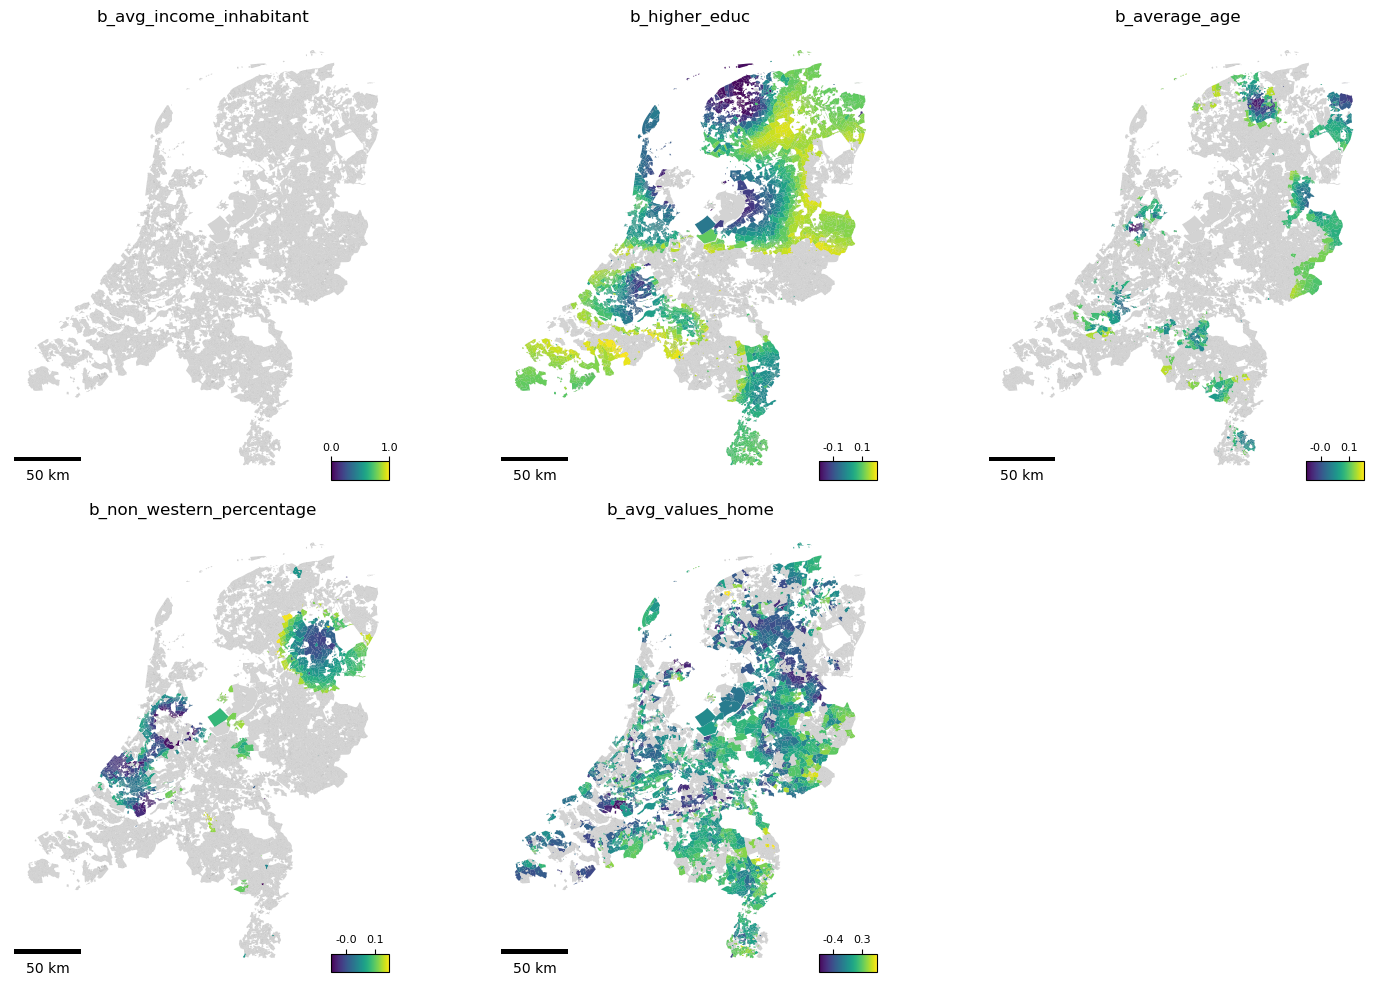

In [109]:
# Coefficient estimates
coef_estimates = joined_mgwr[['b_avg_income_inhabitant', 'b_higher_educ', 'b_average_age', 'b_non_western_percentage', 'b_avg_values_home']].values

# Standard errors
standard_errors = joined_mgwr[['se_avg_income_inhabitant', 'se_higher_educ', 'se_average_age', 'se_non_western_percentage', 'se_avg_values_home']].values

# Calculate t-values
t_values = coef_estimates / standard_errors

is_significant = (t_values >= -1.96) & (t_values <= 1.96)  # Significance level at 95%

columns_to_plot = ['b_avg_income_inhabitant', 'b_higher_educ', 'b_average_age', 'b_non_western_percentage', 'b_avg_values_home']
num_columns = len(columns_to_plot)
num_rows = 2
num_cols = (num_columns + 1) // 2  # Round up division for odd number of columns

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# flatten the axs array if there is only one row
if num_rows == 1:
    axs = [axs]

# iterate over the columns and create subplots
for i, column in enumerate(columns_to_plot):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axs[row_index][col_index]

    # Plot significant regions with original colormap
    significant_data = joined_mgwr[is_significant[:, i]]
    significant_data.plot(column=column, cmap='viridis', linewidth=0.01, ax=ax, edgecolor='black', legend=False)

    # Plot non-significant regions with gray color and thicker boundaries
    non_significant_color = 'lightgray'
    joined_mgwr[~is_significant[:, i]].plot(color='lightgray', ax=ax, linewidth=0.01, edgecolor='black', legend=False)

    ax.set_title(column)
    ax.axis('off')

    # Add small legend based on significant data
    axins = inset_axes(ax, width='15%', height='4%', loc='lower right')
    if significant_data.empty:
        cmin, cmax = 0, 1  # Default values for empty data
        below, above = 0, 1
    else:
        cmin, cmax = np.min(significant_data[column]), np.max(significant_data[column])
        below = 0.25 * (cmax - cmin) + cmin
        above = 0.75 * (cmax - cmin) + cmin
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=cmin, vmax=cmax))
    sm.set_array([])  # dummy empty array
    cbar = plt.colorbar(sm, cax=axins, orientation='horizontal', ticks=[below, above])
    cbar.ax.set_xticklabels([f'{below:.1f}', f'{above:.1f}'], fontsize=8)
    axins.xaxis.set_ticks_position('top')

    # Add scale bar
    ax.add_artist(ScaleBar(1, location="lower left"))

# remove unused subplots
for i in range(num_columns, num_rows * num_cols):
    row_index = i // num_cols
    col_index = i % num_cols
    fig.delaxes(axs[row_index][col_index])

plt.tight_layout()

# Save the plot in 300 dpi
# plt.savefig('plot_mgwr_significant_results.png', dpi=300)
plt.show()

## Inequality using GINI index

### Non-weighted Gini index

In [27]:
# load non-aggregated file for the analysis
joined_data_buurt = gpd.read_file('data_collection/cleaned_data/joined_data_buurt.gpkg')

In [63]:
gdf_gini = joined_data_buurt.copy()
gdf_gini.head()

BU_CODE                                           geometry      VGVI  \
2   BU07189998  MULTIPOLYGON (((23205.420 400019.760, 23084.51...  0.057300   
3   BU07189998  MULTIPOLYGON (((23205.420 400019.760, 23084.51...  0.028638   
8   BU02309997  MULTIPOLYGON (((184523.380 495471.756, 184537....  0.104294   
9   BU02309997  MULTIPOLYGON (((184523.380 495471.756, 184537....  0.159436   
20  BU19669998  POLYGON ((238429.400 621278.700, 238889.010 62...  0.000000   

    population  
2          NaN  
3          NaN  
8          NaN  
9          NaN  
20         NaN

In [45]:
def calculate_gini_index(data):
    """
    Calculates the Gini index for a given one-dimensional input.

    Parameters:
    data (array-like): Input data array.

    Returns:
    float: Gini index value.
    """
    n = len(data)
    mean_value = np.mean(data)
    diff_sum = np.sum(np.abs(np.subtract.outer(data, data)))
    gini_index = diff_sum / (2 * n * n * mean_value)
    return gini_index

# Group by 'BU_CODE' and calculate Gini index
gini_indices = []
for buurt, group in joined_data_buurt.groupby('BU_CODE'):
    vgvi_values = group['VGVI'].values
    gini_index = calculate_gini_index(vgvi_values)
    gini_indices.append({'buurt': buurt, 'gini_index': gini_index})

gini_df = pd.DataFrame(gini_indices)
merged_gini_df = buurt_cbs_vgvi_merged.merge(gini_df, left_on='BU_CODE', right_on='buurt', how='left')
merged_gini_df.head()

BU_CODE  BU_CODE_COUNT           BU_NAAM   WK_CODE GM_CODE    GM_NAAM  \
0  BU00140000            193  Binnenstad-Noord  WK001400  GM0014  Groningen   
1  BU00140001            338   Binnenstad-Zuid  WK001400  GM0014  Groningen   
2  BU00140002            217   Binnenstad-Oost  WK001400  GM0014  Groningen   
3  BU00140003             68   Binnenstad-West  WK001400  GM0014  Groningen   
4  BU00140004             78  Noorderplantsoen  WK001400  GM0014  Groningen   

   IND_WBI  H2O POSTCODE  DEK_PERC  ...  avg_income_recipient  \
0        1  NEE     9712         1  ...                  24.4   
1        1  NEE     9711         1  ...                  24.9   
2        1  NEE     9711         3  ...                  23.7   
3        1  NEE     9718         1  ...                   NaN   
4        1  NEE     9717         2  ...                   NaN   

   avg_income_stand_household_1000  population  average_age  \
0                             19.8      4505.0    31.958935   
1                             19.4      6410.0    32.583853   
2                             18.9      4170.0    33.603118   
3                              NaN      1715.0    34.569971   
4                              NaN        10.0    65.000000   

   western_percentage  non_western_percentage  higher_educ      VGVI  \
0           18.756937               10.432852    41.509434  0.095778   
1           18.096724               11.778471    45.709828  0.131716   
2           17.985612               14.388489    44.124700  0.154358   
3           19.533528                9.620991    45.481050  0.123234   
4           50.000000                0.000000          NaN  0.270919   

        buurt  gini_index  
0  BU00140000    0.471060  
1  BU00140001    0.343605  
2  BU00140002    0.247732  
3  BU00140003    0.436964  
4  BU00140004    0.174128  

[5 rows x 73 columns]

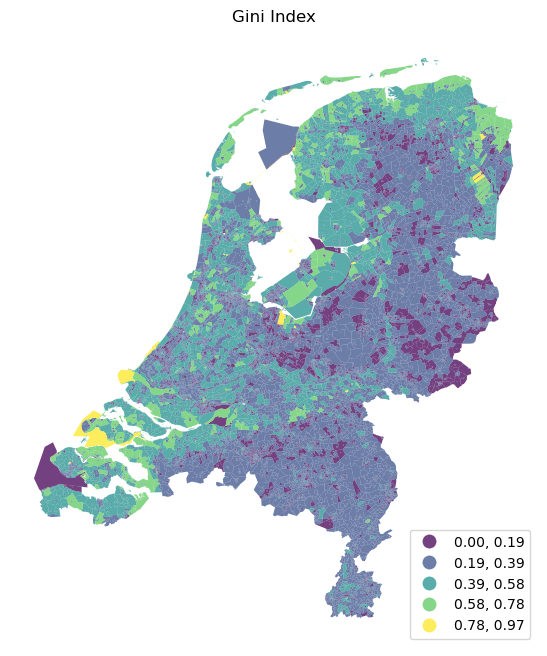

In [85]:
fig, ax = plt.subplots(figsize=(8, 8))
merged_gini_df = gpd.GeoDataFrame(merged_gini_df, geometry='geometry')
merged_gini_df.plot(column="gini_index", cmap='viridis', scheme="equal_interval", k=5, edgecolor="white",
                    linewidth=0.0, alpha=0.75, legend=True, ax=ax)

# Move the legend to the side
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 0.2))  

ax.set_axis_off()
ax.set_title("Gini Index")

plt.show()

### Weighted Gini index by population

In [77]:
def calculate_weighted_gini_index(x, w):
    """
    Calculate the weighted Gini index.

    This function takes two input arrays, `x` and `w`, representing values and weights, respectively.
    It adopts the implementation from https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python.

    Args:
        x (array-like): Values array.
        w (array-like): Weights array.

    Returns:
        float: Weighted Gini index.

    """
    # convert input arrays to numpy arrays
    x = np.asarray(x)
    w = np.asarray(w)
    
    # sort x and w in ascending order of x
    sorted_indices = np.argsort(x)
    sorted_x = x[sorted_indices]
    sorted_w = w[sorted_indices]
    
    # calculate cumulative sums
    cumw = np.cumsum(sorted_w, dtype=float)
    cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
    
    # calculate the weighted Gini index
    weighted_gini_index = (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /
                           (cumxw[-1] * cumw[-1]))
    
    return weighted_gini_index

gini_indices = []
for buurt, group in gdf_gini.groupby('BU_CODE'):
    vgvi_values = group['VGVI'].values
    population_weights = group['population'].values
    gini_index = calculate_weighted_gini_index(vgvi_values, population_weights)
    gini_indices.append({'buurt': buurt, 'gini_index': gini_index})

gini_df = pd.DataFrame(gini_indices)
merged_w_gini_df = buurt_cbs_vgvi_merged.merge(gini_df, left_on='BU_CODE', right_on='buurt', how='left')

In [32]:
# save the results for QGIS visualisation
merged_w_gini_df.to_file('visualisation/vgvi_gini_buurt_ned.gpkg', driver="GPKG")

In [49]:
summary_stats = merged_w_gini_df['gini_index'].describe()

# create the summary DataFrame
summary_df = pd.DataFrame({
    "Statistic": ["Count", "Mean", "Standard Deviation", "Minimum", "25th Percentile",
                   "50th Percentile (Median)", "75th Percentile", "Maximum"],
    "Value": summary_stats.round(2)
})

summary_df = summary_df.set_index('Statistic', drop=True)
summary_df

Value
Statistic                         
Count                     13295.00
Mean                          0.28
Standard Deviation            0.12
Minimum                      -0.00
25th Percentile               0.20
50th Percentile (Median)      0.25
75th Percentile               0.33
Maximum                       0.93

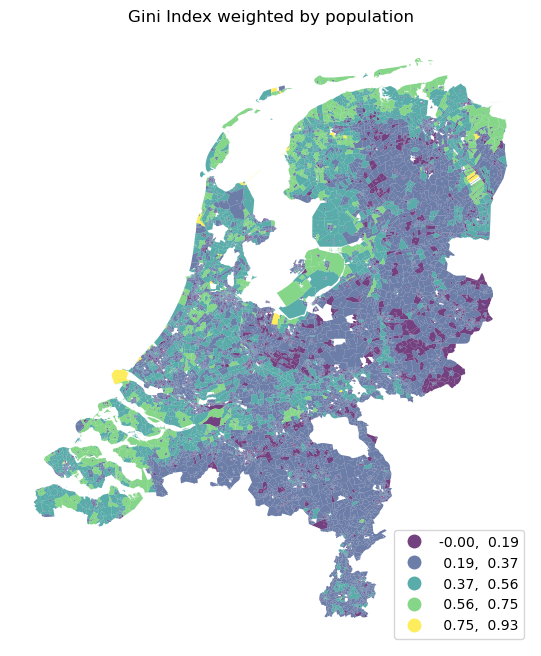

In [88]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))
merged_w_gini_df = gpd.GeoDataFrame(merged_w_gini_df, geometry='geometry')
merged_w_gini_df.plot(column="gini_index", cmap='viridis', scheme="equal_interval", k = 5, edgecolor="white", linewidth=0.0, alpha=0.75, legend=True, ax=ax)

# Move the legend to the side
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 0.2))  

ax.set_axis_off()
ax.set_title("Gini Index weighted by population")
plt.show()